In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
train, val, test = tfds.load('caltech101', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incompleteWVZQUK/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incompleteWVZQUK/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [3]:
for image, label in train.take(1):
  print(image.shape, image.dtype)
  print(label.shape, label.dtype)

(225, 300, 3) <dtype: 'uint8'>
() <dtype: 'int64'>


In [4]:
def resize(image, height=224, width=224):
  return tf.keras.layers.Resizing(height=height, width=width)(image)

train = train.map(lambda image, label: (resize(image), label))
val = val.map(lambda image, label: (resize(image), label))
test = test.map(lambda image, label: (resize(image), label))

In [5]:
for image, label in train.take(1):
  print(image.shape, image.dtype)
  print(label.shape, label.dtype)

(224, 224, 3) <dtype: 'float32'>
() <dtype: 'int64'>


In [6]:
train = train.map(lambda image, label: (tf.keras.applications.mobilenet_v2.preprocess_input(image), label))
val = val.map(lambda image, label: (tf.keras.applications.mobilenet_v2.preprocess_input(image), label))
test = test.map(lambda image, label: (tf.keras.applications.mobilenet_v2.preprocess_input(image), label))

In [7]:
train = train.shuffle(1000, seed=42).batch(32).prefetch(1)
test = test.batch(32).prefetch(1)
val = val.batch(32).prefetch(1)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=20/360, fill_mode="constant", seed=42),
    tf.keras.layers.RandomZoom(height_factor=(-0.15,0.15), fill_mode="constant", seed=42),
])

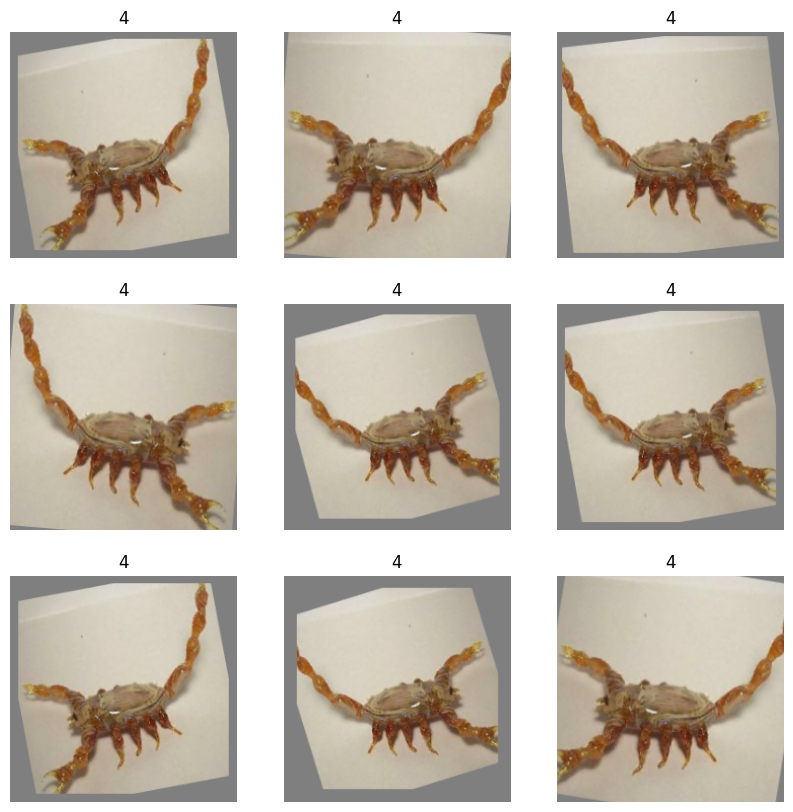

In [9]:
import matplotlib.pyplot as plt

for images, labels in val.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[2]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow( (augmented_image[0].numpy() + 1)/2)
        plt.title(int(labels[0]))
        plt.axis("off")

In [10]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=[224, 224, 3])

for layer in base_model.layers:
  layer.trainable = False

input = tf.keras.layers.Input(shape=[224, 224, 3])
data_aug = data_augmentation(input)
base_model_output = base_model(data_aug, training=False)

global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = tf.keras.layers.Dropout(0.4)(global_avg_pool)
output = tf.keras.layers.Dense(units=102, activation="softmax")(dropout)

model = tf.keras.Model(inputs=[input], outputs=[output])

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [13]:
escb = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=0.001, restore_best_weights=True, monitor="val_accuracy")
model.fit(train, validation_data=val, epochs=100, callbacks=[escb])

Epoch 1/100
96/96 [==============================] - 28s 158ms/step - loss: 3.0677 - accuracy: 0.3624 - val_loss: 1.0502 - val_accuracy: 0.8028
Epoch 2/100
96/96 [==============================] - 8s 82ms/step - loss: 0.9025 - accuracy: 0.7938 - val_loss: 0.6677 - val_accuracy: 0.8356
Epoch 3/100
96/96 [==============================] - 11s 105ms/step - loss: 0.5462 - accuracy: 0.8676 - val_loss: 0.5510 - val_accuracy: 0.8639
Epoch 4/100
96/96 [==============================] - 9s 84ms/step - loss: 0.3708 - accuracy: 0.9121 - val_loss: 0.4377 - val_accuracy: 0.8866
Epoch 5/100
96/96 [==============================] - 8s 81ms/step - loss: 0.3076 - accuracy: 0.9180 - val_loss: 0.4597 - val_accuracy: 0.8833
Epoch 6/100
96/96 [==============================] - 9s 83ms/step - loss: 0.2473 - accuracy: 0.9402 - val_loss: 0.4149 - val_accuracy: 0.8863
Epoch 7/100
96/96 [==============================] - 9s 90ms/step - loss: 0.1973 - accuracy: 0.9510 - val_loss: 0.4103 - val_accuracy: 0.8863


In [19]:
[layer.name for layer in base_model.layers].index('block_13_expand')

116

In [20]:
base_model.trainable = True
for layer in base_model.layers[:116]:
  layer.trainable=False

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662

In [22]:
escb = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=0.001, restore_best_weights=True, monitor="val_accuracy")
model.fit(train, validation_data=val, epochs=100, callbacks=[escb])

Epoch 1/100
96/96 [==============================] - 24s 133ms/step - loss: 0.2646 - accuracy: 0.9291 - val_loss: 0.3983 - val_accuracy: 0.8892
Epoch 2/100
96/96 [==============================] - 10s 101ms/step - loss: 0.2301 - accuracy: 0.9350 - val_loss: 0.4174 - val_accuracy: 0.8797
Epoch 3/100
96/96 [==============================] - 12s 112ms/step - loss: 0.1929 - accuracy: 0.9435 - val_loss: 0.3486 - val_accuracy: 0.9001
Epoch 4/100
96/96 [==============================] - 10s 96ms/step - loss: 0.1819 - accuracy: 0.9441 - val_loss: 0.4203 - val_accuracy: 0.8826
Epoch 5/100
96/96 [==============================] - 12s 118ms/step - loss: 0.1651 - accuracy: 0.9526 - val_loss: 0.3790 - val_accuracy: 0.8912
Epoch 6/100
96/96 [==============================] - 10s 99ms/step - loss: 0.1536 - accuracy: 0.9572 - val_loss: 0.4032 - val_accuracy: 0.8879


In [23]:
model.evaluate(test)

96/96 [==============================] - 5s 50ms/step - loss: 0.3135 - accuracy: 0.9076


[0.31347185373306274, 0.9076265692710876]

In [24]:
top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")
top3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy", top5, top3])

In [25]:
model.evaluate(test)

96/96 [==============================] - 5s 38ms/step - loss: 0.3135 - accuracy: 0.9076 - top5: 0.9859 - top3: 0.9750


[0.31347185373306274,
 0.9076265692710876,
 0.9858645796775818,
 0.9750164151191711]